In [2]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

Minimum value:  [-1.3]


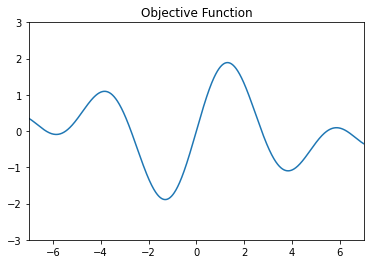

In [25]:
# Objective Function
f = lambda x: (np.sin(1.4*x) + np.sin(0.9*x)).flatten()
#f = lambda x: (0.25*(x**2)).flatten()
x_min = -7
x_max = 7
x = np.arange(x_min, x_max, 0.01)

#find the true minimum
opt_idx = np.where(f(x)==f(x).min())
x_star = np.asarray(x)[opt_idx[0]]
print("Minimum value: ", x_star)

plt.plot(x, f(x))
plt.axis([x_min, x_max, -3, 3])
plt.title('Objective Function')
plt.show()

In [17]:
class Bayes_Opt:
    def __init__(self,f,xmin,xmax):
        self.f = f
        self.s = 0.00005   #variance of noise
        self.sigma = 1.0
        self.l = 1.0
        self.xmin = xmin
        self.xmax = xmax
        
        self.num_iterations = 20
        
        #compute testing set to make predictions
        self.n = 500     #number of points to predict
        self.Xtest = np.linspace(self.xmin,self.xmax,self.n).reshape(-1,1)
        #compute similarity of test set
        #this doesn't change at each iteration
        self.K_star_star = self.kernel(self.Xtest,self.Xtest)
        
        #empty arrays to hold the objective function evaluation data
        self.X = []
        self.y = []
        
        #posterior distribution
        self.mu_post = []
        self.sig_post = []
        
    def compute_posterior(self,X,y):
        """compute mean and variance of posterior"""
        N = len(X)
        #compute L (square root of covariance matrix)
        K = self.kernel(X, X)
        L = LA.cholesky(K + self.s*np.eye(N))
        
        Lk = LA.solve(L, self.kernel(X, self.Xtest))
        #alpha = LA.solve(L,y)
        mu_star = np.dot(Lk.T, LA.solve(L,y))

        #compute variance of test set
        s_ = np.diag(self.K_star_star) - np.sum(Lk**2,axis=0)
        s_star = np.sqrt(s_)
        
        return mu_star, s_star, L, Lk

    def kernel(self, a, b):
        """RBF Kernel from Nando De Freitas youtube videos"""
        sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
        return self.sigma * np.exp(-0.5/self.l * sqdist)
    
    def run(self):
        
        print("Running optimization...")
        
        #first guess
        x_next = np.random.uniform(self.xmin,self.xmax,size=(1,1))
        self.X.append(x_next)
        self.y.append(self.f(x_next) + self.s*np.random.rand(1))
        
        count = 0
        
        #loop
        while(count < self.num_iterations):
        
            X_ = np.asarray(self.X).reshape(-1,1)
            y_ = np.asarray(self.y)
            
            #compute posterior distribution statistics
            mu_star, sig_star, L, Lk = self.compute_posterior(X_,y_)
            
            self.mu_post.append(mu_star)
            self.sig_post.append(sig_star)
            
            #compute next obj. function point to evaluate
            x_next = self.compute_x_next(L,Lk,mu_star)
            self.X.append(x_next)
            self.y.append(self.f(x_next) + self.s*np.random.rand(1))
            
            #update counter
            count+=1
            
        print("iterations complete")
            
    def compute_x_next(self, L, Lk, mu_star):
        #draw realizations from posterior distribution
        
        L = LA.cholesky(self.K_star_star + 1e-6 * np.eye(self.n) - np.dot(Lk.T, Lk))
        f_post = mu_star.reshape(-1,1) + np.dot(L, np.random.normal(size=(self.n,10)))
        
        #find the index of the minimum
        idx = np.where(f_post == f_post.min())
        return self.Xtest[idx[0]]
    
    
    def plot_results(self):
        #Plot posterior statistics
        X_ = np.asarray(self.X).reshape(-1,1)
        y_ = np.asarray(self.y)
        mu_post = self.mu_post[-1].squeeze()
        sig_post = self.sig_post[-1]
        
        plt.plot(X_,y_ ,'k+', ms=18, label='observation')
        plt.plot(self.Xtest, self.f(self.Xtest), 'b-', label='true')
        plt.gca().fill_between(self.Xtest.flat, mu_post-2*sig_post**2, mu_post+2*sig_post**2, color="#dddddd")
        plt.plot(self.Xtest, mu_post, 'r--', lw=2, label='prediction')
        plt.title('Mean predictions plus 2 st.deviations')
        plt.legend()
        plt.show()
        
    def get_f_evals(self):
        return self.X, self.y

Running optimization...
iterations complete


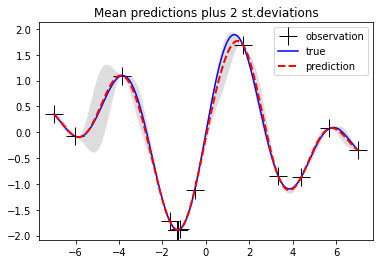

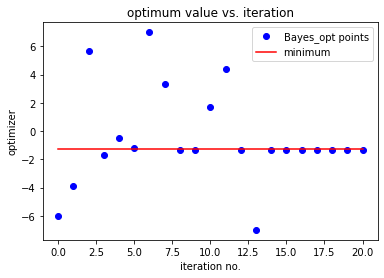

In [24]:
#Initialize Bayesian Optimizer
bo = Bayes_Opt(f,x_min,x_max)
#run the optimizer
bo.run()
#get optimizer
X,y =bo.get_f_evals()
#plot
bo.plot_results()

#plot optimizer value vs iteration number
plt.plot(np.asarray(X).squeeze(),'bo',label='Bayes_opt points')
plt.plot(x_star * np.ones(np.shape(y)),'r',label='minimum')
plt.xlabel('iteration no.')
plt.ylabel('optimizer')
plt.legend()
plt.title('optimum value vs. iteration')
plt.show()